# Week 1 Lab: Transformer Attention on CASIA-Iris-Thousand Dataset


This lab demonstrates how Vision Transformers (ViTs) attend to different regions of biometric iris images.
The CASIA-Iris-Thousand dataset is used to analyze how multi-head self-attention focuses on various spatial features.


## 1. Environment Setup

In [1]:
# Install required packages
!pip install torch torchvision transformers matplotlib numpy opencv-python pillow kagglehub --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
import kagglehub

## 2. Constants

In [3]:
IMG_HEIGHT, IMG_WIDTH = 224, 224

## 3. Dataset Acquisition via KaggleHub

In [4]:
# Download CASIA-Iris-Thousand dataset
path = kagglehub.dataset_download("sondosaabed/casia-iris-thousand")
image_base_path = os.path.join(path, "CASIA-Iris-Thousand")

## 4. Load Dataset and Prepare DataFrame

In [5]:
# Recursively parse all image files from dataset directory
def load_dataset(base_path):
    image_paths, labels = [], []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith((".bmp", ".jpg", ".png")):
                image_paths.append(os.path.join(root, file))
                labels.append(os.path.basename(root))
    return pd.DataFrame({"ImagePath": image_paths, "Label": labels})

df = load_dataset(image_base_path)
print(f"Loaded {len(df)} images from: {image_base_path}")
df.sample(5)

Loaded 20000 images from: /kaggle/input/casia-iris-thousand/CASIA-Iris-Thousand


ImagePath Label
18250  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...     L
8407   /kaggle/input/casia-iris-thousand/CASIA-Iris-T...     R
19515  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...     L
12824  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...     R
10087  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...     R

## 5. Display Random Iris Image Samples

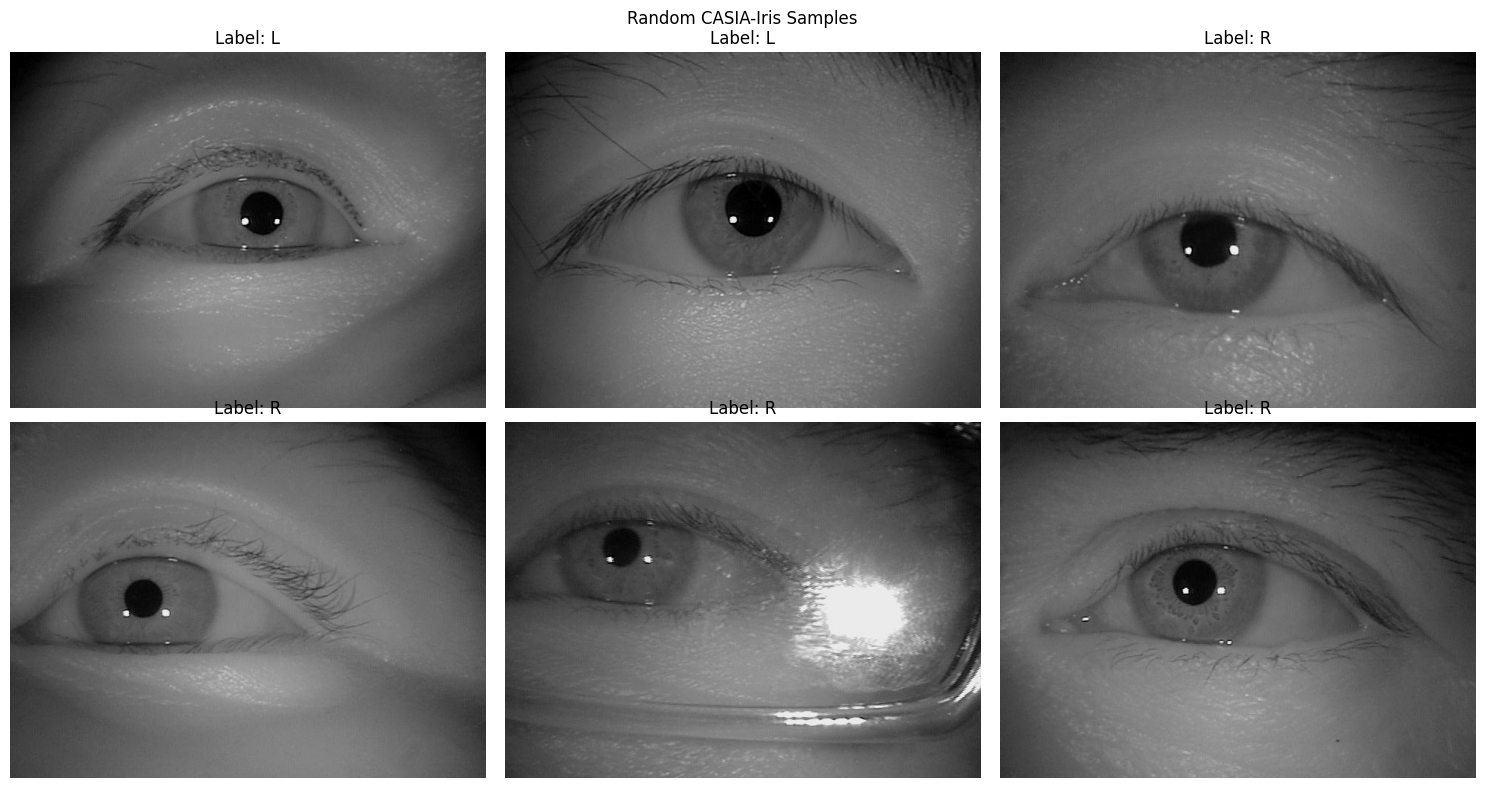

In [6]:
def show_random_samples(df, num=6):
    num = min(num, len(df))
    indices = random.sample(range(len(df)), num)
    cols, rows = 3, math.ceil(num / 3)
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        img = Image.open(df.loc[idx, "ImagePath"])
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {df.loc[idx, 'Label']}")
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Random CASIA-Iris Samples")
    plt.tight_layout()
    plt.show()

show_random_samples(df)

## 6. Preprocess Images with Aspect Ratio Preservation

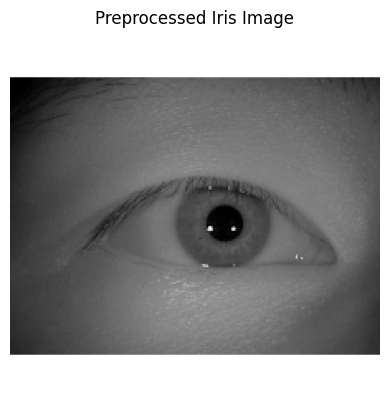

In [7]:
# Resize and pad image to maintain aspect ratio and fit model input dimensions
def resize_keep_aspect_ratio(img, target_height=IMG_HEIGHT, target_width=IMG_WIDTH, pad_value=255):
    h, w = img.shape[:2]
    aspect = w / h
    if aspect > target_width / target_height:
        new_w, new_h = target_width, int(target_width / aspect)
    else:
        new_h, new_w = target_height, int(target_height * aspect)

    resized = cv2.resize(img, (new_w, new_h))
    padded = np.full((target_height, target_width), pad_value, dtype=np.uint8)
    y_off, x_off = (target_height - new_h) // 2, (target_width - new_w) // 2
    padded[y_off:y_off + new_h, x_off:x_off + new_w] = resized
    return padded

def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return resize_keep_aspect_ratio(img)

# Show one preprocessed image
sample_path = df.iloc[10]["ImagePath"]
plt.imshow(preprocess_image(sample_path), cmap='gray')
plt.title("Preprocessed Iris Image")
plt.axis("off")
plt.show()

## 7. Compare Raw vs Preprocessed Iris Image

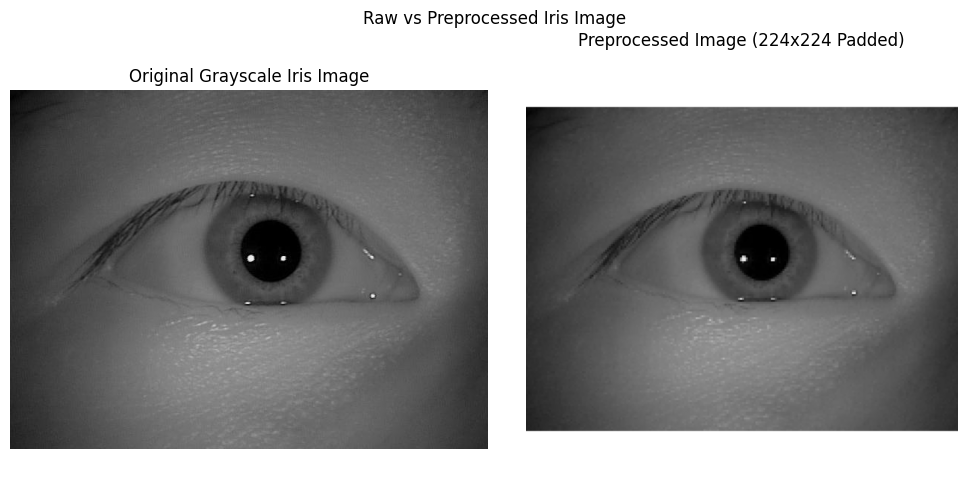

In [8]:

# Load and compare original vs preprocessed images
sample_index = 15
raw_path = df.loc[sample_index, "ImagePath"]
raw_img_gray = cv2.imread(raw_path, cv2.IMREAD_GRAYSCALE)
processed_img = preprocess_image(raw_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(raw_img_gray, cmap="gray")
ax1.set_title("Original Grayscale Iris Image")
ax1.axis("off")

ax2.imshow(processed_img, cmap="gray")
ax2.set_title("Preprocessed Image (224x224 Padded)")
ax2.axis("off")

plt.suptitle("Raw vs Preprocessed Iris Image")
plt.tight_layout()
plt.show()

## 8. Load Pre-trained Vision Transformer

In [9]:
# Load Vision Transformer base model
model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, attn_implementation="eager")
model.eval()
print("Model loaded:", model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model loaded: google/vit-base-patch16-224


## 9. Extract Attention Maps from [CLS](https://h2o.ai/wiki/classify-token/) Token

In [10]:
# Extract attention maps from all transformer layers
def get_attention_maps(image, model, feature_extractor):
    if image.mode != "RGB":
        image = image.convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    return {i: attn.detach().numpy() for i, attn in enumerate(outputs.attentions)}

## 10. Visualize Attention Heads (CLS Token to Patches)

In [11]:
# Visualize attention from the CLS token to patches for selected heads
def visualize_cls_attention(image, attention_maps, layer_index=11, num_heads=4):
    img_array = np.array(image.resize((224, 224)))
    layer_attention = attention_maps[layer_index]
    grid_size = int((layer_attention.shape[-1] - 1) ** 0.5)

    fig, axes = plt.subplots(1, num_heads, figsize=(num_heads * 4, 4))
    if num_heads == 1:
        axes = [axes]

    for h in range(num_heads):
        cls_attn = layer_attention[0, h, 0, 1:]
        grid = cls_attn.reshape(grid_size, grid_size)
        norm = grid / grid.max()
        attn_resized = cv2.resize(norm, (224, 224))
        heatmap = cv2.applyColorMap(np.uint8(255 * attn_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = 0.5 * img_array + 0.5 * heatmap
        axes[h].imshow(overlay.astype(np.uint8))
        axes[h].set_title(f"Head {h+1}")
        axes[h].axis("off")

    plt.suptitle(f"CLS Token Attention – Layer {layer_index}")
    plt.tight_layout()
    plt.show()

## 11. Run Attention Visualization on One Iris Image

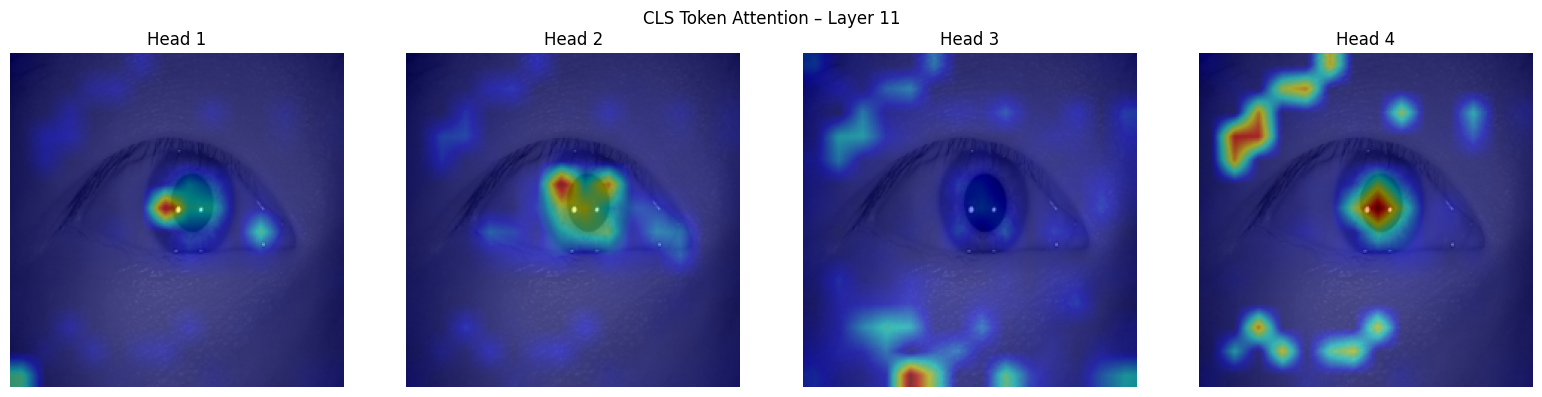

In [12]:
# Select image and extract attention
img_path = df.iloc[15]["ImagePath"]
pil_img = Image.open(img_path).convert("RGB").resize((224, 224))
attention_maps = get_attention_maps(pil_img, model, feature_extractor)
visualize_cls_attention(pil_img, attention_maps, layer_index=11, num_heads=4)

## 12. Attention Heatmap without Overlay

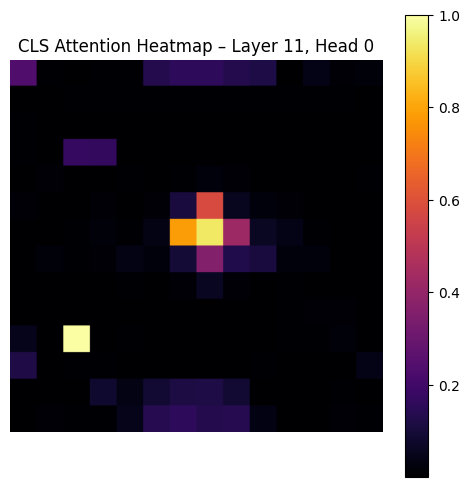

In [13]:

pil_processed = Image.fromarray(processed_img).convert("RGB")
attention_maps_proc = get_attention_maps(pil_processed, model, feature_extractor)

def visualize_attention_heatmap_only(attn_maps, layer_index=11, head_index=0):
    attn = attn_maps[layer_index][0, head_index, 0, 1:]
    grid_size = int(np.sqrt(attn.shape[0]))
    grid = attn.reshape(grid_size, grid_size)
    norm_grid = grid / grid.max()
    resized = cv2.resize(norm_grid, (224, 224), interpolation=cv2.INTER_NEAREST)

    plt.figure(figsize=(6, 6))
    plt.imshow(resized, cmap="inferno")
    plt.title(f"CLS Attention Heatmap – Layer {layer_index}, Head {head_index}")
    plt.axis("off")
    plt.colorbar()
    plt.show()

# Show the raw heatmap
visualize_attention_heatmap_only(attention_maps_proc, layer_index=11, head_index=0)

## 13. Multi-Head x Multi-Layer Attention Visualization

In [14]:
# Function to visualize CLS token attention across multiple heads and layers.
# This helps illustrate how attention patterns evolve across transformer depth.
def visualize_attention_grid(image, attention_maps, layers=[0, 3, 6, 11], heads=[0, 1, 2, 3]):
    '''
    Parameters:
        image: PIL RGB image resized to 224x224
        attention_maps: dictionary of {layer_idx: attention_tensor}
        layers: list of layer indices to visualize
        heads: list of head indices per layer to visualize
    '''
    # Convert image to array for overlay
    img_array = np.array(image.resize((224, 224)))

    # Create a grid of subplots with rows = layers, cols = heads
    fig, axes = plt.subplots(len(layers), len(heads), figsize=(4 * len(heads), 4 * len(layers)))

    for i, layer_index in enumerate(layers):
        for j, head_index in enumerate(heads):
            cls_attn = attention_maps[layer_index][0, head_index, 0, 1:]  # CLS token to all patches
            grid_size = int(np.sqrt(cls_attn.shape[0]))
            grid = cls_attn.reshape(grid_size, grid_size)
            norm = grid / grid.max()
            attn_resized = cv2.resize(norm, (224, 224))
            heatmap = cv2.applyColorMap(np.uint8(255 * attn_resized), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            overlay = 0.5 * img_array + 0.5 * heatmap
            ax = axes[i][j]
            ax.imshow(overlay.astype(np.uint8))
            ax.set_title(f"Layer {layer_index} Head {head_index}")
            ax.axis("off")

    plt.suptitle("CLS Attention Across Layers and Heads", fontsize=16)
    plt.tight_layout()
    plt.show()


## 14. Average CLS Attention Across Layers

In [15]:
# This function computes average attention across heads for a given set of layers
# and overlays it on the input image to highlight high-importance regions.
def visualize_avg_attention_per_layer(image, attention_maps, layers=[0, 3, 6, 11]):
    '''
    Parameters:
        image: PIL RGB image resized to 224x224
        attention_maps: dictionary of attention tensors from ViT
        layers: list of layer indices to visualize
    '''
    img_array = np.array(image.resize((224, 224)))
    fig, axes = plt.subplots(1, len(layers), figsize=(4 * len(layers), 4))

    for i, layer_index in enumerate(layers):
        # Average across all heads at this layer
        avg_attn = attention_maps[layer_index][0, :, 0, 1:].mean(axis=0)
        grid_size = int(np.sqrt(avg_attn.shape[0]))
        grid = avg_attn.reshape(grid_size, grid_size)
        norm = grid / grid.max()
        attn_resized = cv2.resize(norm, (224, 224))
        heatmap = cv2.applyColorMap(np.uint8(255 * attn_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = 0.5 * img_array + 0.5 * heatmap
        axes[i].imshow(overlay.astype(np.uint8))
        axes[i].set_title(f"Layer {layer_index}")
        axes[i].axis("off")

    plt.suptitle("Average CLS Attention Across Layers", fontsize=16)
    plt.tight_layout()
    plt.show()


## 15. Execute Multi-Head and Average Layer Visualization

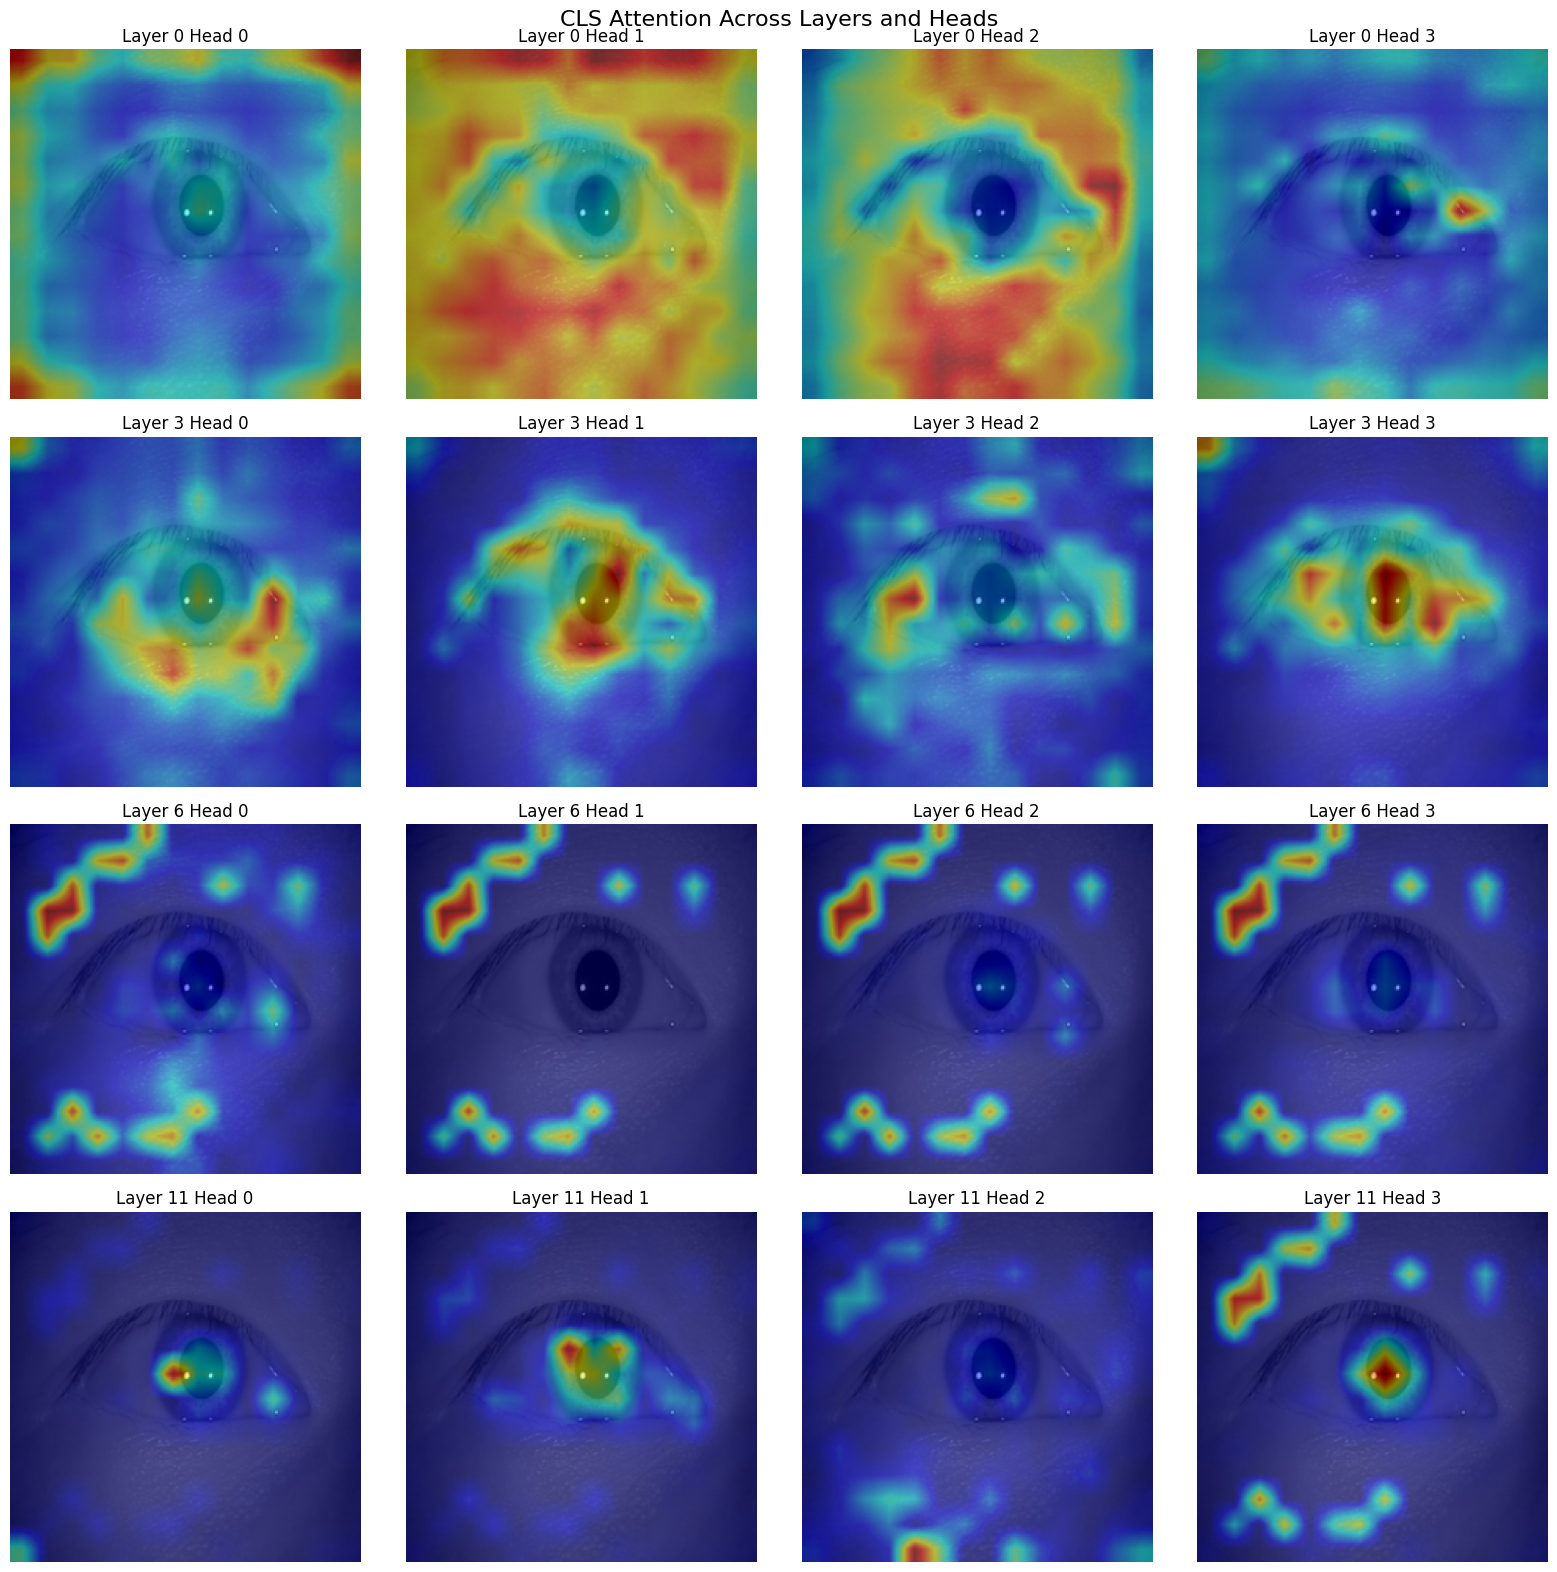

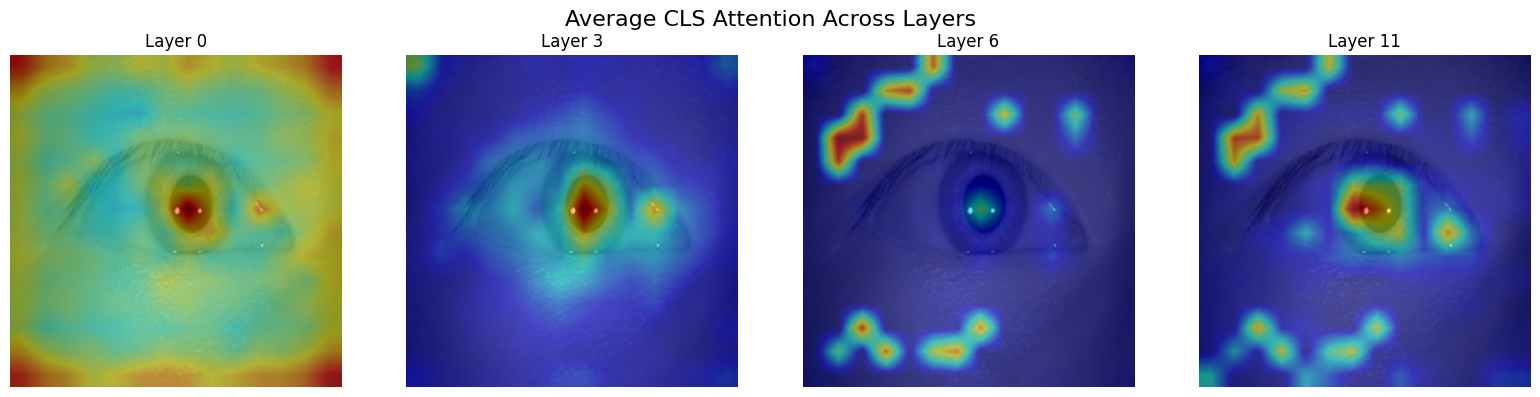

In [16]:
# Reuse previously loaded image (pil_img) and attention maps
# Ensure image is resized to 224x224 and in RGB
visualize_attention_grid(pil_img, attention_maps, layers=[0, 3, 6, 11], heads=[0, 1, 2, 3])
visualize_avg_attention_per_layer(pil_img, attention_maps, layers=[0, 3, 6, 11])


FURTHER ANALYSIS (MASKING): https://arxiv.org/html/2402.06497v2